## Package imports

In [2]:
# Backbone imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
# Single Cell imports
import anndata
import scanpy as sc
import scrublet as scr
import harmonypy
from pybiomart import Server

import warnings
warnings.filterwarnings(action="ignore")

# package settings

In [3]:
sc.settings.verbosity = 3 # verbosity: errors (0), warnings (1), info (2), hints (3)  package.module.command
#sc.settings.writedir()
sc.logging.print_header()
%matplotlib inline

scanpy==1.8.2 anndata==0.8.0 umap==0.5.3 numpy==1.22.4 scipy==1.8.1 pandas==1.4.2 scikit-learn==1.0.2 statsmodels==0.13.2 python-igraph==0.9.10 pynndescent==0.5.7


In [4]:
data_dir = Path("C:/Users/gperry/OneDrive - The Jackson Laboratory/Documents/GSBE Project - meeting recordings/molecule_files")
#data_dir = Path("C:/Users/gperry/OneDrive - The Jackson Laboratory/Documents/GSBE Project - meeting recordings/molecule_files")

## Functions

In [5]:
#### Query Functions ####

def query_ribosomal_genes(biomart_annos):
    """feeds biomart_annos into function, """
    return biomart_annos.loc[             # returns the location in biomart
        biomart_annos.go_id.isin(["GO:0005840"]) |   #This GO ID must be 005840
        biomart_annos.external_gene_name.str.lower().str.match("^m?rp[ls]\d+"), # \d+ one or more digits
        "external_gene_name"
    ].dropna().unique()
def query_mitochondrial_genes(biomart_annos):
    return biomart_annos.loc[
        biomart_annos.chromosome_name.str.match("^(mt|MT)") & True, 
        "external_gene_name"
    ].dropna().unique()
def query_hemoglobin_genes(biomart_annos):
    return biomart_annos.loc[
        biomart_annos.go_id.isin(["GO:0005833"]),
        "external_gene_name"
    ].dropna().unique()
def query_proliferation_genes(biomart_annos):
    return biomart_annos.loc[
        biomart_annos.go_id.isin(["GO:0008283"]),
        "external_gene_name"
    ].dropna().unique()
def query_xlinked_genes(biomart_annos):
    return biomart_annos.loc[
        biomart_annos.chromosome_name.str.match("^(chrX|X|x|chrx)") & True, 
        "external_gene_name"
    ].dropna().unique()
def query_ylinked_genes(biomart_annos):
    return biomart_annos.loc[
        biomart_annos.chromosome_name.str.match("^(chrY|Y|y|chry)") & True, 
        "external_gene_name"
    ].dropna().unique()
#### Annotation Functions #####################################################################
def annotate_var(adata, species):
    biomart_annos = sc.queries.biomart_annotations(
        species, 
        ["external_gene_name", "chromosome_name", "go_id"], 
        use_cache=True
    )
    #cc_genes = pd.Index(pd.read_csv("cell_cycle.csv", header=0, index_col=1).index[:484])
    #cc_genes = cc_genes.tolist() + cc_genes.str.capitalize().tolist()
    #stress_genes = pd.read_csv("coregene_stress-response.csv", header=0, index_col=6).index
    #stress_genes = stress_genes.tolist() + stress_genes.str.capitalize().tolist()
    idx = adata.var.species.isin([species])
    adata.var.loc[idx, "hemoglobin"] = adata.var_names.isin(query_hemoglobin_genes(biomart_annos))[idx]
    adata.var.loc[idx, "mitochondrial"] = adata.var_names.isin(query_mitochondrial_genes(biomart_annos))[idx]
    adata.var.loc[idx, "ribosomal"] = adata.var_names.isin(query_ribosomal_genes(biomart_annos))[idx]
    adata.var.loc[idx, "x_linked"] = adata.var_names.isin(query_xlinked_genes(biomart_annos))[idx]
    adata.var.loc[idx, "y_linked"] = adata.var_names.isin(query_ylinked_genes(biomart_annos))[idx]
    adata.var.loc[idx, "sex_linked"] = adata.var_names.isin(["Xist", "XIST"])[idx] | adata.var.y_linked[idx]
    adata.var.loc[idx, "proliferation"] = adata.var_names.isin(query_proliferation_genes(biomart_annos))[idx]
    #adata.var.loc[idx, "cell_cycle"] = adata.var_names.isin(cc_genes)[idx]
    #adata.var.loc[idx, "stress_response"] = adata.var_names.isin(stress_genes)[idx]
    adata.var.loc[idx, "exclude_from_highly_variable"] =  \
        adata.var.proliferation[idx] | \
        adata.var.hemoglobin[idx] | \
        adata.var.mitochondrial[idx] | \
        adata.var.ribosomal[idx] | \
        adata.var.sex_linked[idx]
        #adata.var.stress_response[idx] | \
        #adata.var.cell_cycle[idx] | \       
################################################################################   
def annotate_raw_10x_data(output_path: Path, species: str):
    """
    Use to load and quickly annotate a filtered_feature_bc_matrix.h5
    """
    assert species in ["mmusculus", "hsapiens", "hsapiens+mmusculus"]
    output_path = Path(output_path)
    filtered_h5_files = list(output_path.rglob("filtered_*.h5"))
    if filtered_h5_files:
        filtered_h5_file = filtered_h5_files[0]
    else:
        raise FileNotFoundError(f"Could not find 'filtered_*.h5' under {output_path}")
    output_id = output_path.stem
    adata = sc.read_10x_h5(filtered_h5_file)
    soupX_dirs = list(output_path.rglob("soupX"))
    if soupX_dirs:
        soupX_dir = soupX_dirs[0]
        adata.layers["soupX"] = sc.read_10x_mtx(soupX_dir).X.copy()
    else:
        adata.layers["soupX"] = adata.X.copy()
    adata.obs["processed_id"] = output_id
    seqsat_files = list(output_path.rglob("sequencing_saturation.csv"))
    if seqsat_files:
        seqsat = pd.read_csv(seqsat_files[0], index_col=0, header=0)
        adata.obs.loc[seqsat.index, "sequencing_saturation"] = seqsat["saturation"].values 
    for key in ["hemoglobin", "mitochondrial", "ribosomal", "x_linked", "y_linked", "sex_linked", "exclude_from_highly_variable"]:
        adata.var[key] = False    
    if species == "hsapiens+mmusculus":
        adata.var["is_human"] = adata.var.genome.isin(["GRCh38"])
        adata.var["species"] = "mmusculus"
        adata.var.loc[adata.var.is_human, "species"] = "hsapiens"
    
        adata.var_names = adata.var_names.str.extract("(GRCh38|mm10)_+(.*)").iloc[:,1]
    else:
        adata.var["is_human"] = species == "hsapiens"
        adata.var["species"] = species
    adata.var_names_make_unique()  
    for specie in species.split("+"):
        annotate_var(adata, specie)             # this calls annotate_var() then runs qc metrics
    sc.pp.calculate_qc_metrics(
        adata,
        qc_vars=("mitochondrial", "hemoglobin", "ribosomal", "sex_linked", "is_human"),
        percent_top=None,
        log1p=True,
        inplace=True
    )  
    scrub = scr.Scrublet(adata.X)
    doublet_scores, predicted_doublets = scrub.scrub_doublets()
    adata.obs["scrublet_putative_doublet"] = predicted_doublets
    adata.obs["scrublet_score"] = doublet_scores  
    adata.raw = adata
    adata.layers["raw"] = adata.X.copy()
    adata.layers["log_raw"] = sc.pp.log1p(adata.X,copy=True).copy()
    adata.layers["log_soupX"] = sc.pp.log1p(adata.layers["soupX"],copy=True)  
    return adata
#### QC Functions ###############################################################################

def qc_metrics_violin(adata):
    titles = ["UMIs", "Genes","% mtRNA", "% rRNA", "Hemoglobin"]
    keys = [
        "total_counts", "n_genes_by_counts", "pct_counts_mitochondrial", 
        "pct_counts_ribosomal", "total_counts_hemoglobin"
    ]
    L = len(keys)
    fig, axs = plt.subplots(1, L, figsize=(L*2, 3), dpi=200, gridspec_kw=dict(wspace=1))

    for ax, key, title in zip(axs.flat, keys, titles):
        sc.pl.violin(adata, key, layer="log_raw", color="0.85", use_raw=False, ax=ax, show=False, size=0.5, jitter=0.4, stripplot=False)
        ax.set_xlabel(""); ax.set_ylabel(adata.obs.processed_id.head(1).values[0])
        ax.set_xticks([])
        ax.set_title(title)
        sns.despine(fig, ax)
    fig.subplots_adjust(wspace=1)
    return fig

## Import Directory and sample import

In [6]:
# output id as well as short hand mapping we might use later
output_id_mapping = {
    "PR19050": "primary_tumor_1", 
    "PR19051": "primary_tumor_2", 
    "PR19052": "primary_tumor_3", 
    "SC2100407": "pdx_nsg-il6_1", 
    "SC2100408": "pdx_nsg", 
    "SC2100424": "pdx_nsg-il6_2",
    "SC2100426": "pdo"
}

In [7]:
input_paths = [data_dir / output_id for output_id in output_id_mapping.keys()]  #

In [8]:
species = "hsapiens+mmusculus"
raws = [annotate_raw_10x_data(p, species) for p in input_paths]    # This is running annotate_raw_10x_data() and setting it equal to "raws"

reading C:\Users\gperry\OneDrive - The Jackson Laboratory\Documents\GSBE Project - meeting recordings\molecule_files\PR19050\filtered_feature_bc_matrix.h5
 (0:00:01)
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.41
Detected doublet rate = 1.1%
Estimated detectable doublet fraction = 25.1%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 4.5%
Elapsed time: 10.8 seconds
reading C:\Users\gperry\OneDrive - The Jackson Laboratory\Documents\GSBE Project - meeting recordings\molecule_files\PR19051\filtered_feature_bc_matrix.h5
 (0:00:00)
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.41
Detected doublet rate = 1.9%
Estimated detectable doublet fraction = 34.7%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 5.6%
Elapsed time: 10.3 seconds
reading C:\Users\gperr

## QC the data
- Look some violin plots
- Decide per-variable threshold
- Also look at % contamination between species

#output_path = data_dir / "raw.h5ad"

In [9]:
#raws

sc.pl.scatter(raws[0], x="log1p_total_counts", y="pct_counts_is_human")

In [10]:
# Don't remove any genes here (as it will make integration harder)
# But remove cells based on whatever you want
qc_params = {
    "min_genes_per_cell": 800,
    "max_pct_counts_mitochondrial": 20,
    "max_counts_hemoglobin": 50, 
}

qcs = []
for raw in raws:
    qc = raw.copy()
    sc.pp.filter_cells(qc, min_genes=qc_params.get("min_genes_per_cell", 800))
    idx = qc.obs.pct_counts_mitochondrial < qc_params.get("max_pct_counts_mitochondrial", 30)
    idx &= qc.obs.total_counts_hemoglobin < qc_params.get("max_counts_hemoglobin", 100)
    qc = qc[idx, :].copy()
    qcs.append(qc)

filtered out 648 cells that have less than 800 genes expressed
filtered out 1121 cells that have less than 800 genes expressed
filtered out 1730 cells that have less than 800 genes expressed
filtered out 1035 cells that have less than 800 genes expressed
filtered out 826 cells that have less than 800 genes expressed
filtered out 635 cells that have less than 800 genes expressed
filtered out 787 cells that have less than 800 genes expressed


## Merging datasets
- Simple concatenation along the genes.  Will batch correct shortly.

In [11]:
merged = anndata.concat(
    qcs, join="outer", label="dataset", keys=output_id_mapping.values(), index_unique="-", 
)
merged.raw = merged.copy()
merged.layers["raw"] = merged.X.copy()

In [12]:
# greedy regex to define grouping variable
# primary_tumor_1 -> primary_tumor
# primary_tumor_2 -> primary_tumor
# pdx_1 -> pdx
merged.obs["data_type"] = merged.obs.dataset.str.extract("(.*)_")

# Merging may or may not remove variable annotations
merged.var["species"] = "hsapiens"
merged.var.loc[merged.var_names.isin(raw.var_names[raw.var.species.isin(["mmusculus"])])] = "mmusculus"

annotate_var(merged, "hsapiens")
annotate_var(merged, "mmusculus")

In [13]:
sc.pp.filter_genes(merged, min_cells=5)
sc.pp.normalize_total(merged, exclude_highly_expressed=True, target_sum=None)
merged.layers["normed"] = merged.X.copy()
sc.pp.log1p(merged)

sc.pp.highly_variable_genes(merged, flavor="cell_ranger", n_top_genes=3000) # should be changed for subclusters
merged.var.loc[merged.var.exclude_from_highly_variable, "highly_variable"] = False

sc.pp.pca(merged, use_highly_variable=True)

for col, dtype in zip(merged.var.columns, merged.var.dtypes):
    if isinstance(dtype, pd.CategoricalDtype):
        if False in merged.var[col]:
            merged.var[col] = merged.var[col].astype(bool)
    else:
        merged.var[col] = merged.var[col].astype(str)

filtered out 22824 genes that are detected in less than 5 cells
normalizing counts per cell The following highly-expressed genes are not considered during normalization factor computation:
['S100A9', 'S100A8', 'GNLY', 'IGKC', 'GCG', 'MTRNR2L12', 'SST', 'APOD', 'IGFBP7', 'FDCSP', 'JCHAIN', 'SPP1', 'SFRP2', 'CLU', 'FABP4', 'CCL19', 'CCL21', 'LCN2', 'PTGDS', 'INS', 'MALAT1', 'MGP', 'IGHG4', 'IGHG2', 'IGHA1', 'IGHG1', 'IGHG3', 'IGHM', 'PLCG2', 'CCL4', 'CCL4L2', 'COL1A1', 'TTR', 'APOE', 'FTL', 'CST3', 'IGLC1', 'IGLC2', 'IGLC3', 'TIMP1', 'MT-CO1', 'MT-ATP6', 'Lcn2', 'Fabp5', 'Fabp4', 'S100a8', 'S100a9', 'Csn3', 'Cxcl2', 'Cxcl13', 'Spp1', 'Ccl24', 'Asprv1', 'Apoe', 'Klk6', 'Ftl1', 'Saa3', 'Saa1', 'Saa2', 'Mt1', 'Hp', 'Mmp3', 'Ltf', 'Srgn', 'Cfd', 'Lyz2', 'Ccl8', 'Ccl5', 'Wfdc17', 'Ctsl', 'Apod', 'Gm26917', 'Gm42418', 'C3-1', 'Cd74', 'Cst6', 'Malat1', 'Fth1', 'Timp1', 'Tmsb4x', 'mt-Co1', 'mt-Co2', 'mt-Atp6', 'mt-Co3']
    finished (0:00:00)
If you pass `n_top_genes`, all cutoffs are ignored.
e

In [14]:
output_path = data_dir / "merged.h5ad"

merged.write(output_path)

In [15]:
merged

AnnData object with n_obs × n_vars = 32743 × 46062
    obs: 'processed_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mitochondrial', 'log1p_total_counts_mitochondrial', 'pct_counts_mitochondrial', 'total_counts_hemoglobin', 'log1p_total_counts_hemoglobin', 'pct_counts_hemoglobin', 'total_counts_ribosomal', 'log1p_total_counts_ribosomal', 'pct_counts_ribosomal', 'total_counts_sex_linked', 'log1p_total_counts_sex_linked', 'pct_counts_sex_linked', 'total_counts_is_human', 'log1p_total_counts_is_human', 'pct_counts_is_human', 'scrublet_putative_doublet', 'scrublet_score', 'n_genes', 'dataset', 'data_type'
    var: 'species', 'hemoglobin', 'mitochondrial', 'ribosomal', 'x_linked', 'y_linked', 'sex_linked', 'proliferation', 'exclude_from_highly_variable', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'soupX', 'raw', 'log_raw', 'log

## Batch correction with Harmony
Here we need to determine a few covariates across which to integrate the data.  The sky is the limit here, but I would encourage _at least_ correcting for 10x_chemistry version and model types, at bare minimum.  Here's some code to get you started

In [16]:
merged.obs["chemistry"] = "v3"
merged.obs.loc[merged.obs.data_type.isin(["primary_tumor"]), "chemistry"] = "v2"

outs = harmonypy.run_harmony(
    merged.obsm["X_pca"], 
    meta_data=merged.obs, 
    vars_use=["chemistry", "data_type"], 
    theta=[2, 2]
)
merged.obsm["X_pca_harmony"] = outs.Z_corr.T

sc.pp.neighbors(merged, use_rep="X_pca_harmony", n_neighbors=20, metric="correlation")

sc.tl.umap(merged)

sc.tl.leiden(merged)

sc.tl.rank_genes_groups(merged, "leiden", method="wilcoxon", use_raw=False)

2022-07-09 08:44:38,443 - harmonypy - INFO - Iteration 1 of 10
2022-07-09 08:44:58,614 - harmonypy - INFO - Iteration 2 of 10
2022-07-09 08:45:19,035 - harmonypy - INFO - Iteration 3 of 10
2022-07-09 08:45:37,660 - harmonypy - INFO - Iteration 4 of 10
2022-07-09 08:45:51,857 - harmonypy - INFO - Converged after 4 iterations


computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:31)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:53)
running Leiden clustering
    finished: found 34 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:17)
ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:08:23)


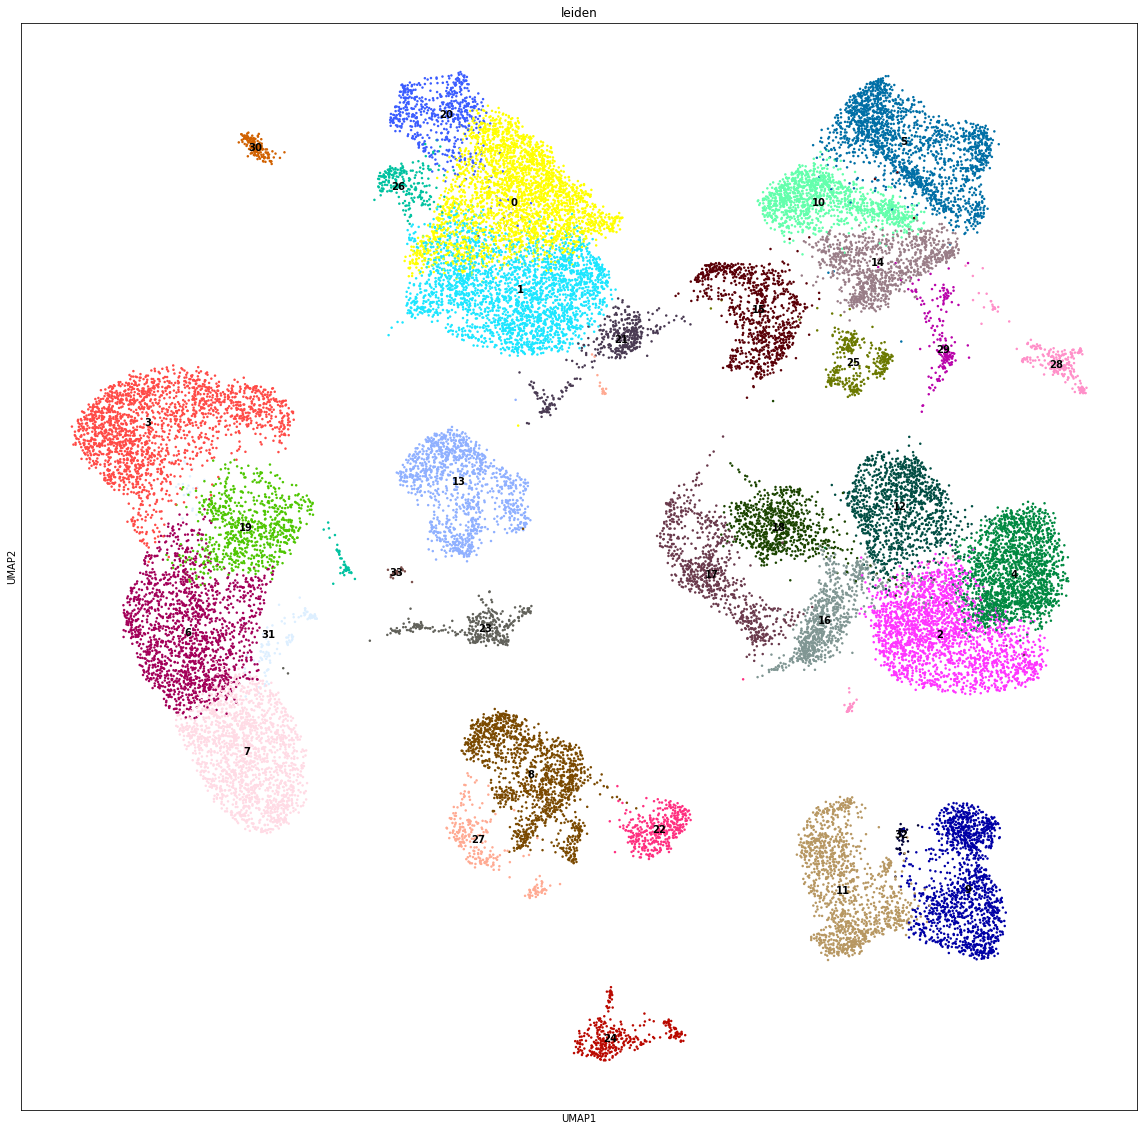

In [124]:

# leiden cluster shows 34 clusters total

fig, ax = plt.subplots(1, 1, figsize=(20, 20))
sc.pl.umap(merged, ax=ax, color="leiden", legend_loc="on data",size=25,use_raw=False)
fig.savefig("C:/Users/gperry/OneDrive - The Jackson Laboratory/Documents/GSBE Project - meeting recordings/figures/GlobalCluster/basic_mapped_cluster.png")


# Get significant genes in each cluster

In [19]:
sc.get.rank_genes_groups_df(merged, "0")


,names,scores,logfoldchanges,pvals,pvals_adj
0,Ctss,81.918579,5.849215,0.0,0.0
1,Fcer1g,81.878059,5.866367,0.0,0.0
2,Lyz2,81.520622,6.876417,0.0,0.0
3,Cyba,80.899498,5.149874,0.0,0.0
4,Tyrobp,80.616348,5.408025,0.0,0.0
...,...,...,...,...,...
46057,EIF1,-48.790009,-5.016528,0.0,0.0
46058,HLA-C,-48.826996,-4.824682,0.0,0.0
46059,DDX5,-48.871819,-4.979143,0.0,0.0
46060,JUND,-49.244682,-5.815377,0.0,0.0


In [20]:
sc.get.rank_genes_groups_df(merged, "1")


,names,scores,logfoldchanges,pvals,pvals_adj
0,Zeb2,74.620171,4.860352,0.0,0.0
1,Malat1,74.265671,6.243571,0.0,0.0
2,Mafb,74.037506,4.934252,0.0,0.0
3,Fcgr2b,72.661591,5.047780,0.0,0.0
4,Grn,71.990669,4.413315,0.0,0.0
...,...,...,...,...,...
46057,JUN,-42.580925,-5.018023,0.0,0.0
46058,H3F3A,-43.375977,-3.905638,0.0,0.0
46059,JUND,-43.803787,-4.042951,0.0,0.0
46060,JUNB,-43.918186,-4.711511,0.0,0.0


In [21]:
sc.get.rank_genes_groups_df(merged, "2")


,names,scores,logfoldchanges,pvals,pvals_adj
0,SRGN,62.371689,3.610015,0.0,0.0
1,CD3D,59.493023,3.775225,0.0,0.0
2,SARAF,58.890797,3.027573,0.0,0.0
3,IL7R,58.245911,4.253019,0.0,0.0
4,JUNB,56.410149,3.234102,0.0,0.0
...,...,...,...,...,...
46057,Tmsb4x,-40.383636,-7.097261,0.0,0.0
46058,mt-Atp6,-40.641235,-9.215041,0.0,0.0
46059,Malat1,-40.825920,-9.587750,0.0,0.0
46060,Actb,-41.242237,-8.488919,0.0,0.0


In [22]:

sc.get.rank_genes_groups_df(merged, "3")


,names,scores,logfoldchanges,pvals,pvals_adj
0,Lgals7,72.776115,7.943751,0.0,0.0
1,Krt14,72.256042,8.210897,0.0,0.0
2,S100a14,72.056206,7.434467,0.0,0.0
3,Sfn,72.030869,7.374930,0.0,0.0
4,Perp,71.106819,6.055352,0.0,0.0
...,...,...,...,...,...
46057,MT-CO2,-55.885876,-11.895628,0.0,0.0
46058,MT-ATP6,-56.465313,-12.012235,0.0,0.0
46059,MT-CO3,-56.593102,-12.036355,0.0,0.0
46060,TMSB4X,-57.175777,-11.065973,0.0,0.0


In [23]:

sc.get.rank_genes_groups_df(merged, "4")


,names,scores,logfoldchanges,pvals,pvals_adj
0,TPT1,65.202652,3.629804,0.0,0.0
1,RPS12,65.201897,3.837545,0.0,0.0
2,RPL13,64.364929,3.555947,0.0,0.0
3,RPS3,63.471600,3.296710,0.0,0.0
4,RPS15A,63.184063,3.388436,0.0,0.0
...,...,...,...,...,...
46057,Malat1,-37.819508,-8.705188,0.0,0.0
46058,Tmsb4x,-37.874462,-7.258319,0.0,0.0
46059,mt-Atp6,-38.029434,-9.406562,0.0,0.0
46060,Actb,-38.545311,-8.145198,0.0,0.0


In [24]:

sc.get.rank_genes_groups_df(merged, "5")


,names,scores,logfoldchanges,pvals,pvals_adj
0,CD37,64.615433,4.110933,0.0,0.0
1,CD79A,64.195534,4.810464,0.0,0.0
2,HLA-DRA,64.059845,4.902945,0.0,0.0
3,HLA-DPB1,63.760204,4.385355,0.0,0.0
4,HLA-DPA1,62.499245,4.047384,0.0,0.0
...,...,...,...,...,...
46057,mt-Atp6,-37.699684,-9.931906,0.0,0.0
46058,Malat1,-37.808380,-9.986145,0.0,0.0
46059,Tmsb4x,-37.859085,-8.791613,0.0,0.0
46060,Actb,-38.349491,-9.930892,0.0,0.0


In [25]:

sc.get.rank_genes_groups_df(merged, "6")


,names,scores,logfoldchanges,pvals,pvals_adj
0,Mgst1,63.589279,5.964557,0.0,0.0
1,Scd1,62.596939,5.350718,0.0,0.0
2,Dbi,62.104202,4.542098,0.0,0.0
3,Thrsp,61.789253,5.507952,0.0,0.0
4,Prdx1,61.755859,3.945866,0.0,0.0
...,...,...,...,...,...
46057,MT-ATP6,-52.555309,-16.399654,0.0,0.0
46058,MT-CO3,-52.656284,-15.426359,0.0,0.0
46059,TMSB4X,-53.253201,-13.350874,0.0,0.0
46060,RPL41,-53.309689,-14.653749,0.0,0.0


In [26]:

sc.get.rank_genes_groups_df(merged, "7")


,names,scores,logfoldchanges,pvals,pvals_adj
0,BC018473,67.547729,7.495848,0.0,0.0
1,4931406C07Rik,67.287773,6.420579,0.0,0.0
2,Lcn2,67.138206,8.115956,0.0,0.0
3,Clca3a2,66.998421,6.954309,0.0,0.0
4,Dbi,66.929367,5.335754,0.0,0.0
...,...,...,...,...,...
46057,MT-ATP6,-52.408676,-11.447349,0.0,0.0
46058,MT-CO3,-52.549656,-11.668681,0.0,0.0
46059,TMSB4X,-53.192097,-12.004444,0.0,0.0
46060,RPL41,-53.213795,-11.520933,0.0,0.0


In [27]:

sc.get.rank_genes_groups_df(merged, "8")


,names,scores,logfoldchanges,pvals,pvals_adj
0,DCN,61.279953,10.101501,0.000000e+00,0.000000e+00
1,COL1A2,61.255180,9.151373,0.000000e+00,0.000000e+00
2,C1S,61.027699,8.309355,0.000000e+00,0.000000e+00
3,C1R,60.892651,7.732987,0.000000e+00,0.000000e+00
4,COL6A2,60.745140,7.437661,0.000000e+00,0.000000e+00
...,...,...,...,...,...
46057,Tmsb4x,-32.174778,-6.570923,3.977692e-227,3.100177e-225
46058,Malat1,-32.391991,-8.303201,3.558779e-230,2.840979e-228
46059,mt-Atp6,-32.405323,-8.328069,2.309540e-230,1.846910e-228
46060,Actb,-32.689526,-7.194636,2.200346e-234,1.816351e-232


In [28]:

sc.get.rank_genes_groups_df(merged, "9")


,names,scores,logfoldchanges,pvals,pvals_adj
0,ACKR1,62.502983,10.772395,0.000000e+00,0.000000e+00
1,VWF,60.648811,7.715933,0.000000e+00,0.000000e+00
2,SPARCL1,59.920601,7.005463,0.000000e+00,0.000000e+00
3,FKBP1A,59.678493,4.503595,0.000000e+00,0.000000e+00
4,PECAM1,59.330250,5.529582,0.000000e+00,0.000000e+00
...,...,...,...,...,...
46057,mt-Atp6,-32.624508,-32.619629,1.842761e-233,1.483938e-231
46058,Malat1,-32.740875,-32.855839,4.094889e-235,3.344304e-233
46059,Tmsb4x,-32.901379,-31.508120,2.100333e-237,1.746310e-235
46060,Actb,-33.147564,-11.903422,6.140404e-241,5.286715e-239


In [29]:

sc.get.rank_genes_groups_df(merged, "10")


,names,scores,logfoldchanges,pvals,pvals_adj
0,IGKC,56.976234,6.980337,0.000000e+00,0.000000e+00
1,IGHM,54.762329,5.463727,0.000000e+00,0.000000e+00
2,CD79A,54.320549,4.925996,0.000000e+00,0.000000e+00
3,IGHD,54.033443,5.667696,0.000000e+00,0.000000e+00
4,CD37,53.653145,4.083355,0.000000e+00,0.000000e+00
...,...,...,...,...,...
46057,mt-Atp6,-30.864019,-13.031793,3.632843e-209,9.785731e-207
46058,Malat1,-30.944416,-12.126416,3.020429e-210,8.183941e-208
46059,Tmsb4x,-31.019234,-10.025647,2.967030e-211,8.232971e-209
46060,Actb,-31.387363,-12.767181,3.009746e-216,8.505209e-214


In [30]:

sc.get.rank_genes_groups_df(merged, "11")


,names,scores,logfoldchanges,pvals,pvals_adj
0,A2M,56.422787,6.160559,0.000000e+00,0.000000e+00
1,RAMP2,56.246464,6.741677,0.000000e+00,0.000000e+00
2,SLC9A3R2,55.650673,7.322920,0.000000e+00,0.000000e+00
3,EPAS1,55.407635,6.052818,0.000000e+00,0.000000e+00
4,EGFL7,54.682320,6.258487,0.000000e+00,0.000000e+00
...,...,...,...,...,...
46057,mt-Atp6,-30.562891,-12.038454,3.811899e-205,5.521500e-203
46058,Malat1,-30.673706,-13.115928,1.276573e-206,1.866714e-204
46059,Tmsb4x,-30.706829,-9.642033,4.613963e-207,6.790044e-205
46060,Actb,-31.082325,-12.235731,4.174914e-212,6.453184e-210


In [31]:

sc.get.rank_genes_groups_df(merged, "12")


,names,scores,logfoldchanges,pvals,pvals_adj
0,CCL5,53.435829,5.973680,0.000000e+00,0.000000e+00
1,GZMK,49.311157,5.850162,0.000000e+00,0.000000e+00
2,HCST,47.798489,3.843395,0.000000e+00,0.000000e+00
3,HLA-C,46.147865,2.974605,0.000000e+00,0.000000e+00
4,B2M,46.120663,3.232560,0.000000e+00,0.000000e+00
...,...,...,...,...,...
46057,Tmsb4x,-29.845753,-7.533741,9.966932e-196,3.400717e-193
46058,mt-Atp6,-29.913300,-10.021270,1.321458e-196,4.646488e-194
46059,Malat1,-29.984243,-9.844429,1.575057e-197,5.580792e-195
46060,Actb,-30.360723,-8.901983,1.813745e-202,6.737476e-200


In [32]:

sc.get.rank_genes_groups_df(merged, "13")


,names,scores,logfoldchanges,pvals,pvals_adj
0,Col1a2,57.203396,8.577764,0.000000e+00,0.000000e+00
1,Bgn,57.145657,8.716240,0.000000e+00,0.000000e+00
2,Col1a1,57.133926,8.830497,0.000000e+00,0.000000e+00
3,Col3a1,57.113033,8.705374,0.000000e+00,0.000000e+00
4,C1s1,56.695774,8.088828,0.000000e+00,0.000000e+00
...,...,...,...,...,...
46057,RPS12,-32.393875,-5.522208,3.347924e-230,1.814260e-228
46058,EEF1A1,-32.432186,-5.017860,9.659569e-231,5.265551e-229
46059,B2M,-32.501099,-4.898570,1.028858e-231,5.668811e-230
46060,RPL14,-32.793827,-5.068515,7.211132e-236,4.121082e-234


In [33]:

sc.get.rank_genes_groups_df(merged, "14")


,names,scores,logfoldchanges,pvals,pvals_adj
0,IGKC,49.934292,6.745667,0.000000e+00,0.000000e+00
1,CD37,44.899300,3.714745,0.000000e+00,0.000000e+00
2,HLA-DRA,44.884567,4.582453,0.000000e+00,0.000000e+00
3,HLA-DPB1,44.543819,4.047827,0.000000e+00,0.000000e+00
4,HLA-DPA1,42.890648,3.663255,0.000000e+00,0.000000e+00
...,...,...,...,...,...
46057,mt-Atp6,-27.091045,-12.808331,1.255432e-161,3.381738e-159
46058,Tmsb4x,-27.112110,-8.797662,7.087993e-162,1.920512e-159
46059,Malat1,-27.185278,-12.282516,9.697655e-163,2.643156e-160
46060,Actb,-27.547606,-11.111979,4.727512e-167,1.344189e-164


In [34]:

sc.get.rank_genes_groups_df(merged, "15")


,names,scores,logfoldchanges,pvals,pvals_adj
0,IGLC2,48.205395,7.224471,0.000000e+00,0.000000e+00
1,IGLC3,47.643852,6.615878,0.000000e+00,0.000000e+00
2,WARS,45.763283,5.049747,0.000000e+00,0.000000e+00
3,IGHG1,45.364670,6.583547,0.000000e+00,0.000000e+00
4,BST2,45.185966,3.774707,0.000000e+00,0.000000e+00
...,...,...,...,...,...
46057,Ncl,-18.852882,-5.520959,2.782620e-79,3.160865e-78
46058,Srrm2,-18.865995,-5.019439,2.171439e-79,2.472092e-78
46059,mt-Nd5,-18.962626,-4.336522,3.473669e-80,4.007116e-79
46060,Rbm39,-19.026997,-4.741846,1.019311e-80,1.185045e-79


In [35]:

sc.get.rank_genes_groups_df(merged, "16")


,names,scores,logfoldchanges,pvals,pvals_adj
0,RNF213,46.934765,5.728025,0.000000e+00,0.000000e+00
1,MTRNR2L12,43.688122,3.735918,0.000000e+00,0.000000e+00
2,NEAT1,40.750084,3.861181,0.000000e+00,0.000000e+00
3,CCL5,40.267601,5.557014,0.000000e+00,0.000000e+00
4,SYNE2,40.150295,4.548223,0.000000e+00,0.000000e+00
...,...,...,...,...,...
46057,Srrm2,-18.893829,-4.326807,1.281981e-79,3.091655e-77
46058,Rbm39,-18.931684,-3.977694,6.253019e-80,1.515929e-77
46059,Son,-19.025848,-3.902445,1.041857e-80,2.580108e-78
46060,Xist,-19.652266,-4.824882,5.528858e-86,1.591689e-83


In [36]:

sc.get.rank_genes_groups_df(merged, "17")


,names,scores,logfoldchanges,pvals,pvals_adj
0,HMGB2,44.525032,5.156910,0.000000e+00,0.000000e+00
1,MKI67,43.170902,6.922065,0.000000e+00,0.000000e+00
2,GZMB,42.425835,6.235435,0.000000e+00,0.000000e+00
3,TUBB,42.350544,4.415655,0.000000e+00,0.000000e+00
4,LAG3,42.088165,4.670146,0.000000e+00,0.000000e+00
...,...,...,...,...,...
46057,Hsp90aa1,-18.271282,-5.348080,1.401194e-74,2.952507e-73
46058,mt-Nd3,-18.539244,-4.669116,9.961197e-77,2.182839e-75
46059,Xist,-19.078182,-5.178086,3.833614e-81,9.192292e-80
46060,Rbm39,-19.299377,-5.626960,5.436064e-83,1.348390e-81


In [37]:

sc.get.rank_genes_groups_df(merged, "18")


,names,scores,logfoldchanges,pvals,pvals_adj
0,NKG7,45.993668,7.071351,0.000000e+00,0.000000e+00
1,GZMA,45.531208,6.685102,0.000000e+00,0.000000e+00
2,IL32,45.062263,5.042131,0.000000e+00,0.000000e+00
3,CST7,45.057423,5.741819,0.000000e+00,0.000000e+00
4,GZMB,44.747791,7.295134,0.000000e+00,0.000000e+00
...,...,...,...,...,...
46057,Xist,-18.070927,-4.239747,5.399985e-73,2.281964e-71
46058,Scand1,-18.098118,-4.655237,3.297421e-73,1.397294e-71
46059,Son,-18.221214,-3.877866,3.502908e-74,1.513611e-72
46060,Rrbp1,-18.273394,-4.084730,1.348029e-74,5.874446e-73


In [38]:

sc.get.rank_genes_groups_df(merged, "19")


,names,scores,logfoldchanges,pvals,pvals_adj
0,Krt7,45.725502,7.251059,0.000000e+00,0.000000e+00
1,Krt18,45.294182,5.332235,0.000000e+00,0.000000e+00
2,Klk10,44.984570,6.570687,0.000000e+00,0.000000e+00
3,Krt8,44.890297,5.337269,0.000000e+00,0.000000e+00
4,Klk6,44.719978,7.233568,0.000000e+00,0.000000e+00
...,...,...,...,...,...
46057,MT-ATP6,-35.003204,-33.876614,2.011024e-268,2.716475e-266
46058,MT-CO3,-35.071213,-33.783783,1.852239e-269,2.569814e-267
46059,TMSB4X,-35.425453,-13.172457,6.927926e-275,1.063714e-272
46060,RPL41,-35.514759,-33.481350,2.909165e-276,4.669058e-274


In [39]:

sc.get.rank_genes_groups_df(merged, "20")


,names,scores,logfoldchanges,pvals,pvals_adj
0,Coro1a,39.575600,5.272627,0.000000e+00,0.000000e+00
1,Cst3,39.195816,5.073347,0.000000e+00,0.000000e+00
2,Cybb,39.142159,5.620862,0.000000e+00,0.000000e+00
3,Plac8,38.149696,5.907908,0.000000e+00,0.000000e+00
4,Ptprc,37.845375,4.760359,0.000000e+00,0.000000e+00
...,...,...,...,...,...
46057,RPS2,-27.136076,-6.239068,3.696769e-162,7.124710e-160
46058,RPS18,-27.155632,-6.025318,2.172504e-162,4.204617e-160
46059,RPL32,-27.182327,-6.199536,1.050895e-162,2.051115e-160
46060,B2M,-27.348257,-6.362623,1.132681e-164,2.278321e-162


In [40]:

sc.get.rank_genes_groups_df(merged, "21")


,names,scores,logfoldchanges,pvals,pvals_adj
0,IGLC2,29.353231,4.810262,2.173000e-189,1.000927e-184
1,Gm42418,27.244669,3.292335,1.922031e-163,4.426630e-159
2,mt-Co1,24.708071,4.496368,8.758574e-135,1.344791e-130
3,Saa3,24.145941,4.416426,8.236979e-129,9.485293e-125
4,Gm15056,23.653627,3.637667,1.083128e-123,9.978207e-120
...,...,...,...,...,...
46057,DUSP1,-14.814109,-5.455742,1.187546e-49,9.767986e-47
46058,TXNIP,-14.956902,-5.429239,1.404130e-50,1.220321e-47
46059,JUNB,-15.218230,-3.224922,2.676756e-52,2.417583e-49
46060,ZFP36L2,-15.261675,-4.131273,1.376678e-52,1.268251e-49


In [41]:

sc.get.rank_genes_groups_df(merged, "22")


,names,scores,logfoldchanges,pvals,pvals_adj
0,TPM2,32.770782,8.402002,1.535875e-235,7.074546e-231
1,MYL9,32.702938,8.085642,1.418554e-234,3.267071e-230
2,TAGLN,32.687218,8.923798,2.372932e-234,3.643399e-230
3,ADIRF,32.562271,7.376802,1.403751e-232,1.616490e-228
4,CALD1,32.499512,6.608462,1.083357e-231,9.980319e-228
...,...,...,...,...,...
46057,mt-Atp6,-16.606741,-10.207109,6.228636e-62,6.946815e-60
46058,Malat1,-16.660116,-10.034925,2.555256e-62,2.891897e-60
46059,Tmsb4x,-16.715794,-8.713678,1.005732e-62,1.155263e-60
46060,Actb,-16.944448,-31.880392,2.115116e-64,2.543772e-62


In [42]:

sc.get.rank_genes_groups_df(merged, "23")


,names,scores,logfoldchanges,pvals,pvals_adj
0,Egfl7,32.064346,9.405013,1.385409e-225,6.381470e-221
1,Pecam1,31.900488,6.814855,2.628784e-223,6.054352e-219
2,Col4a1,31.716541,7.878845,9.190418e-221,1.411097e-216
3,Igfbp7,31.577362,7.685295,7.553644e-219,8.698399e-215
4,Cdh5,31.339603,10.634135,1.348146e-215,1.241966e-211
...,...,...,...,...,...
46057,EEF1A1,-19.525553,-5.373957,6.659205e-85,9.266958e-83
46058,RPL35,-19.570217,-4.627882,2.775014e-85,3.933006e-83
46059,RPL11,-19.626911,-5.718374,9.108772e-86,1.311151e-83
46060,RPS6,-19.646561,-4.947316,6.186582e-86,8.961205e-84


In [43]:

sc.get.rank_genes_groups_df(merged, "24")


,names,scores,logfoldchanges,pvals,pvals_adj
0,SOD1,31.415806,5.380520,1.231004e-216,5.670250e-212
1,KRT8,31.275362,9.449713,1.009466e-214,2.324902e-210
2,KRT18,31.158144,8.908866,3.934462e-213,6.040973e-209
3,C19orf33,31.010077,10.212055,3.942704e-211,4.540221e-207
4,LCN2,30.899570,11.268434,1.210409e-209,1.115077e-205
...,...,...,...,...,...
46057,mt-Atp6,-16.115417,-9.626833,1.988158e-58,7.574736e-57
46058,Malat1,-16.120674,-9.518426,1.826087e-58,6.980351e-57
46059,Tmsb4x,-16.279568,-8.947986,1.378379e-59,5.445188e-58
46060,Actb,-16.389956,-8.993144,2.256101e-60,9.164066e-59


In [44]:

sc.get.rank_genes_groups_df(merged, "25")


,names,scores,logfoldchanges,pvals,pvals_adj
0,BASP1,30.410530,5.207189,3.986647e-203,1.836329e-198
1,HMGN1,30.059175,4.064132,1.656587e-198,3.815286e-194
2,H3F3A,29.851183,3.477896,8.473979e-196,1.301095e-191
3,ARPC2,29.605602,3.348082,1.265646e-192,1.457454e-188
4,ACTG1,29.536655,3.621102,9.745102e-192,8.977577e-188
...,...,...,...,...,...
46057,Malat1,-16.119024,-32.742573,1.875469e-58,1.667719e-56
46058,Tmsb4x,-16.139807,-10.542894,1.339594e-58,1.200474e-56
46059,Actb,-16.333364,-31.878071,5.714354e-60,5.382711e-58
46060,Gm42418,-16.619356,-1.478685,5.047166e-62,5.021222e-60


In [45]:

sc.get.rank_genes_groups_df(merged, "26")


,names,scores,logfoldchanges,pvals,pvals_adj
0,Cd74,27.449999,7.639587,6.947814e-166,3.200302e-161
1,H2-Aa,27.310455,7.666944,3.187045e-164,7.340083e-160
2,H2-Eb1,27.181110,7.640943,1.086235e-162,1.667806e-158
3,H2-Ab1,26.931648,7.508564,9.358703e-160,1.077701e-155
4,Syngr2,25.243252,3.801053,1.343317e-140,1.237517e-136
...,...,...,...,...,...
46057,RPL9,-15.463214,-5.125336,6.145429e-54,5.222707e-52
46058,RPL17,-15.478282,-4.747407,4.862842e-54,4.155700e-52
46059,EIF1,-15.551753,-5.438700,1.548092e-54,1.350535e-52
46060,RPL6,-15.598276,-4.554463,7.478587e-55,6.611875e-53


In [46]:

sc.get.rank_genes_groups_df(merged, "27")


,names,scores,logfoldchanges,pvals,pvals_adj
0,S100A6,25.313314,4.437576,2.279348e-141,1.049913e-136
1,CD63,25.067326,4.556185,1.130178e-138,2.602912e-134
2,CST3,25.041935,6.089832,2.137339e-138,3.281670e-134
3,LGALS1,25.016363,4.648456,4.057696e-138,4.672639e-134
4,RARRES2,24.813234,6.626135,6.452690e-136,5.944476e-132
...,...,...,...,...,...
46057,mt-Co3,-12.715907,-4.601539,4.824807e-37,1.019451e-34
46058,mt-Atp6,-12.845532,-4.678716,9.112233e-38,2.037513e-35
46059,Malat1,-13.069833,-5.515126,4.897325e-39,1.145079e-36
46060,PLCG2,-13.135077,-3.614947,2.072821e-39,4.947062e-37


In [47]:

sc.get.rank_genes_groups_df(merged, "28")


,names,scores,logfoldchanges,pvals,pvals_adj
0,FTH1,27.090778,4.450181,1.264569e-161,5.824856e-157
1,TYROBP,26.540165,9.479164,3.335522e-155,7.682040e-151
2,GRN,24.747614,4.302792,3.289200e-135,5.050237e-131
3,CST3,24.405291,5.033761,1.502718e-131,1.730455e-127
4,LYZ,24.265125,8.495136,4.578493e-130,4.217891e-126
...,...,...,...,...,...
46057,Malat1,-14.211154,-11.388121,7.812739e-46,1.110711e-43
46058,Tmsb4x,-14.252257,-8.758326,4.340242e-46,6.267092e-44
46059,mt-Atp6,-14.271913,-32.504353,3.274706e-46,4.773402e-44
46060,Actb,-14.513274,-31.871656,9.983873e-48,1.580334e-45


In [48]:

sc.get.rank_genes_groups_df(merged, "29")


,names,scores,logfoldchanges,pvals,pvals_adj
0,CD69,17.254015,3.242096,1.043877e-66,4.808304e-62
1,CD37,17.086721,2.962945,1.863620e-65,4.292104e-61
2,BTG1,16.902971,3.122977,4.278025e-64,6.568480e-60
3,IL7R,16.744061,3.353001,6.257020e-63,7.205272e-59
4,RPS12,16.436695,3.172443,1.044612e-60,9.623386e-57
...,...,...,...,...,...
46057,mt-Atp6,-11.593136,-9.788898,4.464797e-31,8.360060e-29
46058,Malat1,-11.633922,-10.019015,2.770707e-31,5.230504e-29
46059,Tmsb4x,-11.767805,-31.408886,5.719310e-32,1.125824e-29
46060,Actb,-11.866116,-31.863672,1.775205e-32,3.586381e-30


In [110]:
sc.get.rank_genes_groups_df(merged, "30")

,names,scores,logfoldchanges,pvals,pvals_adj
0,Junb,20.557564,5.308939,6.585801e-94,3.033552e-89
1,Srgn,20.464125,6.521026,4.496760e-93,1.035649e-88
2,Il1b,20.433554,7.569058,8.414858e-93,1.212243e-88
3,S100a9,20.414822,11.476891,1.234809e-92,1.212243e-88
4,Mcl1,20.411715,5.213897,1.315882e-92,1.212243e-88
...,...,...,...,...,...
46057,RPL26,-12.484333,-4.381723,9.090192e-36,2.379048e-33
46058,RPS18,-12.566570,-4.183150,3.224096e-36,8.486189e-34
46059,RPL30,-12.589533,-4.794711,2.410947e-36,6.419251e-34
46060,EEF1A1,-12.650333,-4.354724,1.114009e-36,3.018440e-34


In [111]:
sc.get.rank_genes_groups_df(merged, "31")

,names,scores,logfoldchanges,pvals,pvals_adj
0,Psmb8,15.406798,3.418873,1.473318e-53,6.786398e-49
1,Pmepa1,15.247795,3.870233,1.702879e-52,2.906881e-48
2,Lmna,15.240873,3.109217,1.893240e-52,2.906881e-48
3,Gm47283,15.208737,3.349113,3.094520e-52,3.563495e-48
4,Itgav,14.430994,4.099345,3.302855e-47,3.042723e-43
...,...,...,...,...,...
46057,RPL32,-11.697321,-5.522713,1.315404e-31,5.508195e-29
46058,MT-ND3,-11.760954,-5.527921,6.202936e-32,2.773977e-29
46059,RPL11,-11.880363,-6.334867,1.497160e-32,7.578262e-30
46060,MTRNR2L12,-11.950871,-5.732223,6.424891e-33,3.595690e-30


In [112]:
sc.get.rank_genes_groups_df(merged, "32")

,names,scores,logfoldchanges,pvals,pvals_adj
0,ECSCR,10.028233,5.836629,1.145482e-23,2.713191e-19
1,TFPI,10.025463,6.916069,1.178061e-23,2.713191e-19
2,S100A10,9.975836,4.849071,1.944578e-23,2.985706e-19
3,CD59,9.942703,5.117906,2.713609e-23,3.124856e-19
4,GNG11,9.864902,5.419273,5.909256e-23,4.968938e-19
...,...,...,...,...,...
46057,mt-Atp6,-5.163842,-32.480484,2.419325e-07,2.134846e-05
46058,Malat1,-5.182260,-32.709885,2.192133e-07,1.956861e-05
46059,Tmsb4x,-5.207665,-31.397064,1.912320e-07,1.737382e-05
46060,Actb,-5.251171,-31.850706,1.511357e-07,1.405636e-05


In [113]:
sc.get.rank_genes_groups_df(merged, "33")

,names,scores,logfoldchanges,pvals,pvals_adj
0,Cald1,8.743111,5.643703,2.267775e-18,1.039026e-13
1,Serpinh1,8.654243,6.346931,4.961958e-18,1.039026e-13
2,Rarres2,8.599502,6.798327,8.006292e-18,1.039026e-13
3,Igfbp7,8.566291,6.814273,1.068719e-17,1.039026e-13
4,Lgals1,8.545128,5.576044,1.283944e-17,1.039026e-13
...,...,...,...,...,...
46057,MT-ND3,-5.507659,-5.972100,3.636367e-08,2.030283e-06
46058,MT-ND2,-5.564651,-6.398088,2.626781e-08,1.551215e-06
46059,MTRNR2L12,-5.571016,-8.301296,2.532582e-08,1.507181e-06
46060,MT-CO1,-5.626113,-6.327543,1.843155e-08,1.155094e-06


In [114]:

# name leiden clusters based on  markers - estimated only
    
merged.obs["cell_type"] = merged.obs.leiden.map({
    "0": "mus_Monocytes_1",
    "1": "mus_Monocytes_2",
    "2": "Hum_T-cells_1",
    "3": "mus_Epithelial_1",
    "4": "Hum_Non-Specific_1",
    "5": "Hum_B-cells_1",
    "6": "mus_Non-Specific_1",
    "7": "mus_Non-Specific_2",
    "8": "Hum_Fibroblasts_1",
    "9": "Hum_Adipocytes & Endothelial_1",
    "10": "Hum_B-cells_2",
    "11": "Hum_Adipocytes & Endothelial cells_2",
    "12": "Hum_NK-cells_1",
    "13": "mus_Fibroblasts_1",
    "14": "Hum_B-cells_3",   
    "15": "Hum_B-cells_4",
    "16": "Hum_NK-cells_2",
    "17": "Hum_NK-cells_3",
    "18": "Hum_NK-cells_4",
    "19": "mus_Pancreatic_endocrine-cells_1",
    "20": "mus_Monocytes_3",
    "21": "mus_Non-Specific_3",
    "22": "Hum_SM-cells_1",
    "23": "mus_Adipocytes & Endothelial_1",
    "24": "Hum_Pancreatic_endocrine-cells_1",
    "25": "Hum_Non-Specific_2",
    "26": "mus_Non-Specific_4",
    "27": "Hum_Non-Specific_3",
    "28": "Hum_Monocytes_1",
    "29": "Hum_B-cells_5",
    "30": "mus_Non-Specific_5",
    "31": "mus_NK-cells_1",
    "32": "Hum_Non-Specific_4",
    "33": "mus_SM-cells_1",
    
}) # cluster ids- these keep all clusters separate


In [115]:
# save dataframe for future analysis

merged_hy = merged

output_path = data_dir / "merged_hy.h5ad"

merged_hy.write(output_path)


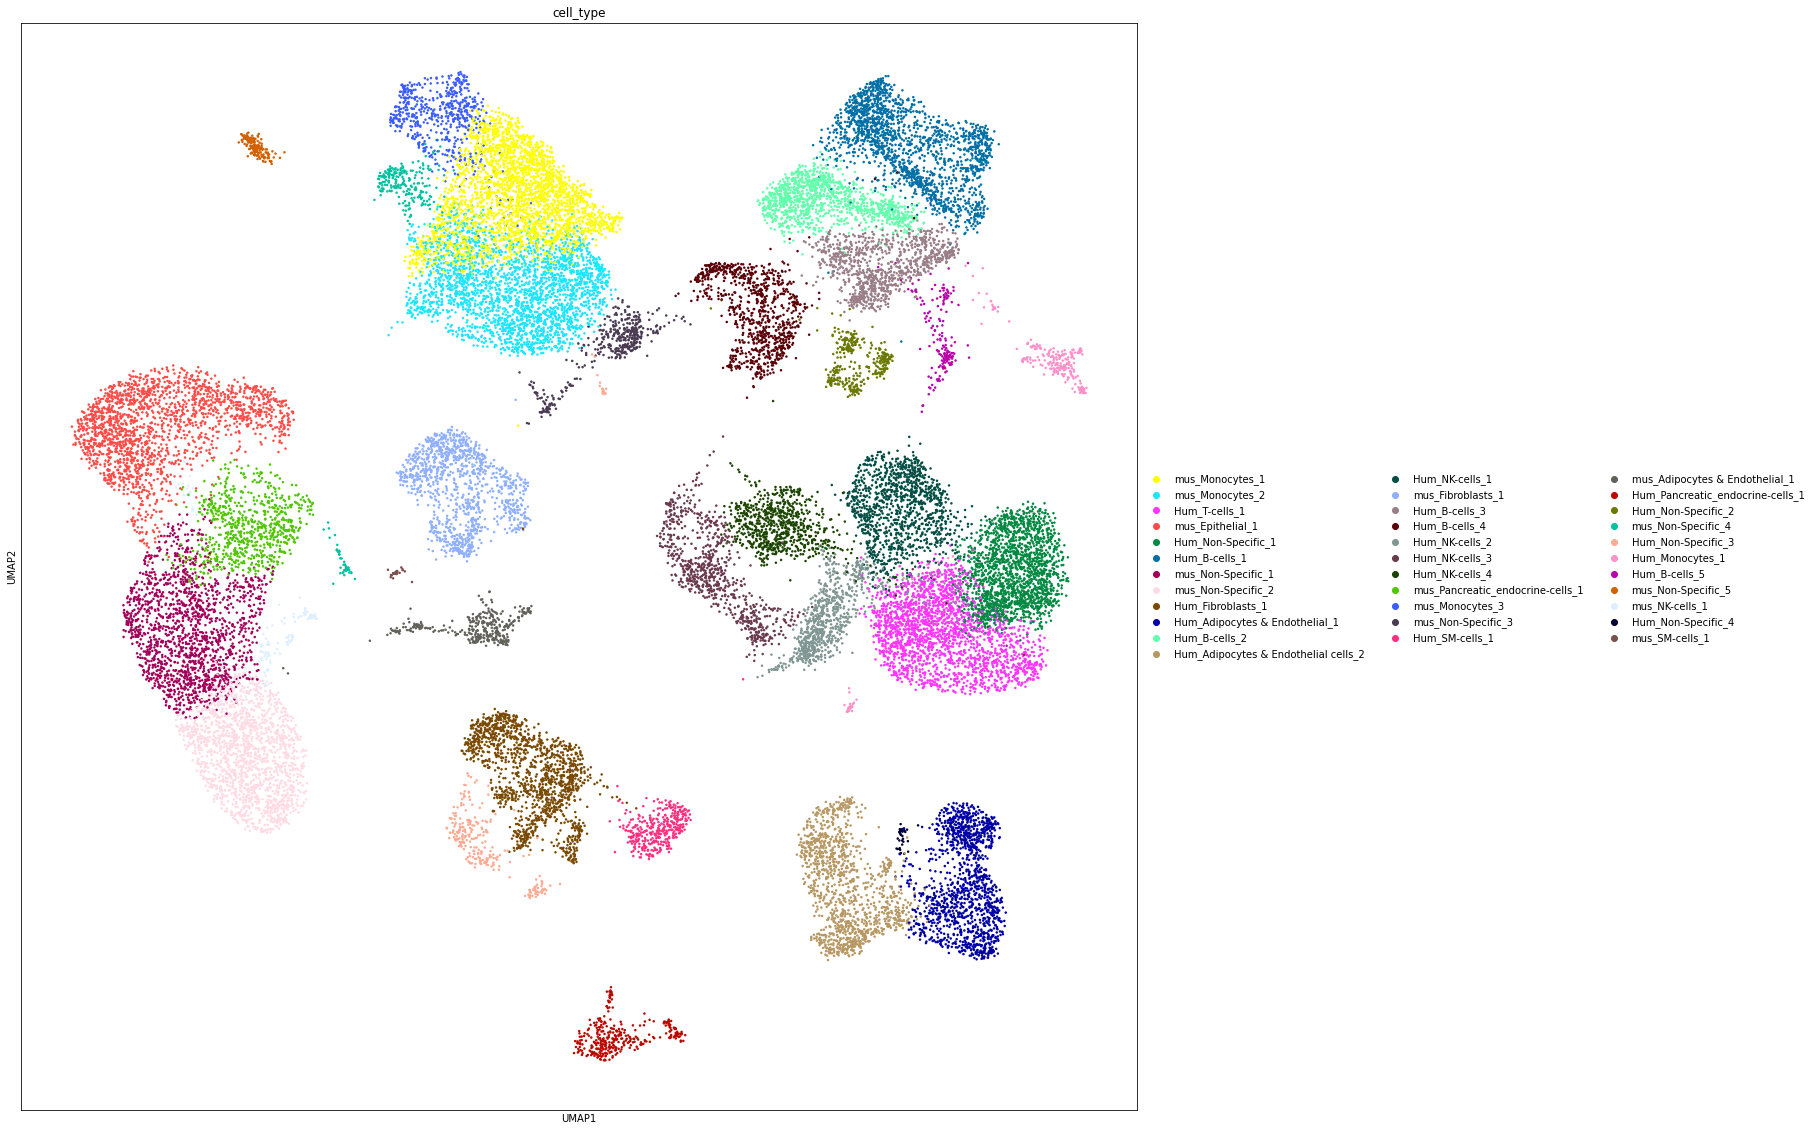

In [128]:
#named clusters

fig, ax = plt.subplots(1, 1, figsize=(20, 20))
sc.pl.umap(merged_hy, ax=ax, color="cell_type", legend_loc="right margin", size=25,use_raw=False)
fig.savefig("C:/Users/gperry/OneDrive - The Jackson Laboratory/Documents/GSBE Project - meeting recordings/figures/GlobalCluster/Global_unique_mapped_cluster.png")


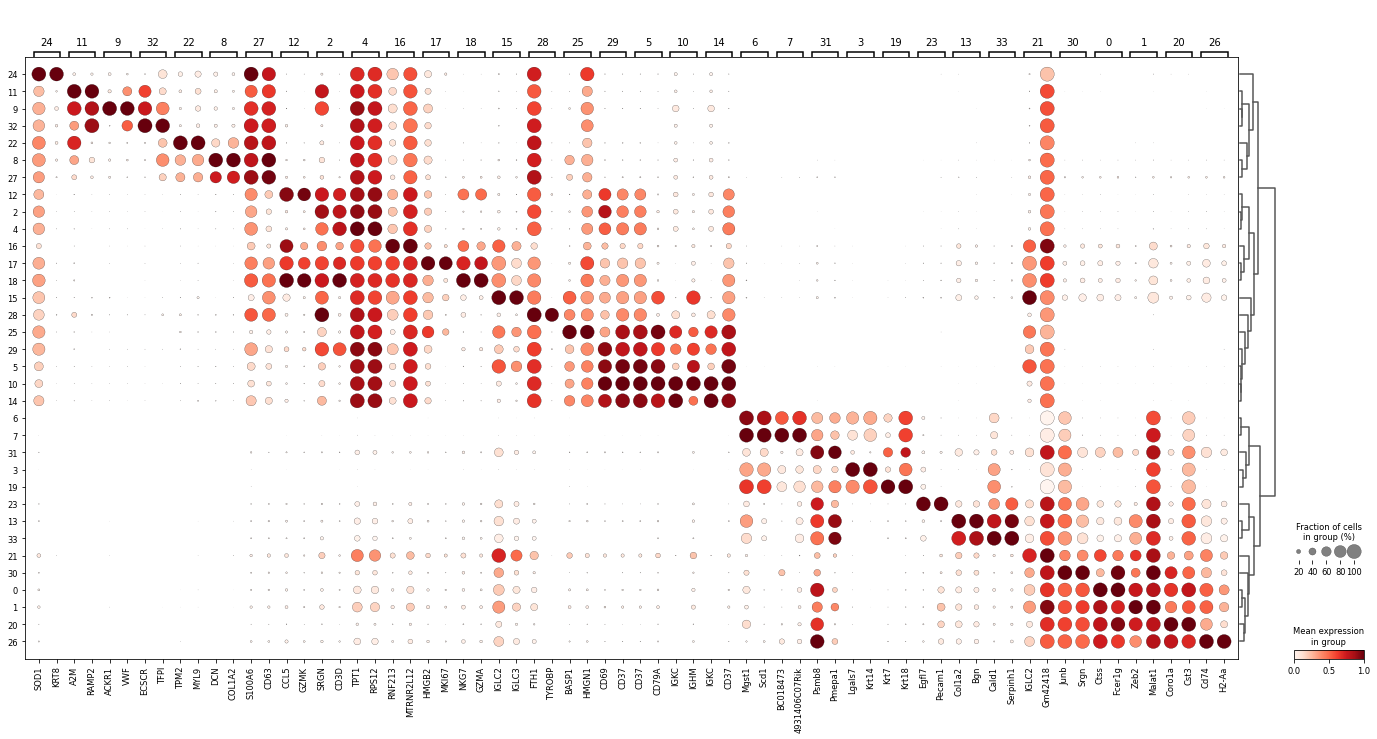

In [117]:
# produce dotplot to view highly expressed genes across clusters n_genes = 2

fig, ax = plt.subplots(1, 1, figsize=(24, 12))
sc.pl.rank_genes_groups_dotplot(merged_hy, ax=ax, n_genes=2, use_raw=False,standard_scale="var")
fig.savefig("C:/Users/gperry/OneDrive - The Jackson Laboratory/Documents/GSBE Project - meeting recordings/figures/GlobalCluster/Global_Dotplot_n2.png")


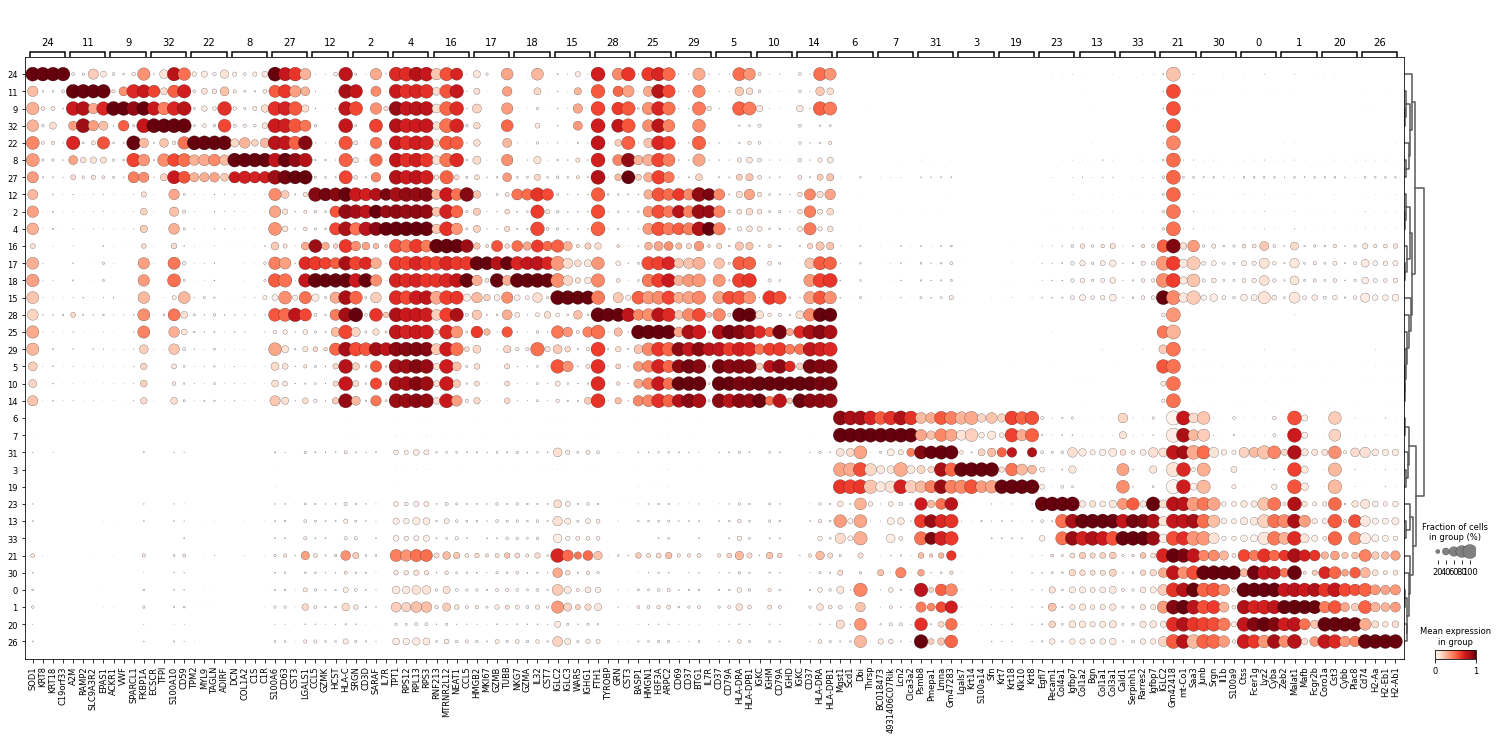

In [118]:

# produce dotplot to view highly expressed genes across clusters, n_genes = 4

fig, ax = plt.subplots(1, 1, figsize=(26, 12))
sc.pl.rank_genes_groups_dotplot(merged_hy, ax=ax, n_genes=4, use_raw=False,standard_scale="var")
fig.savefig("C:/Users/gperry/OneDrive - The Jackson Laboratory/Documents/GSBE Project - meeting recordings/figures/GlobalCluster/Global_Dotplot_n4.png")


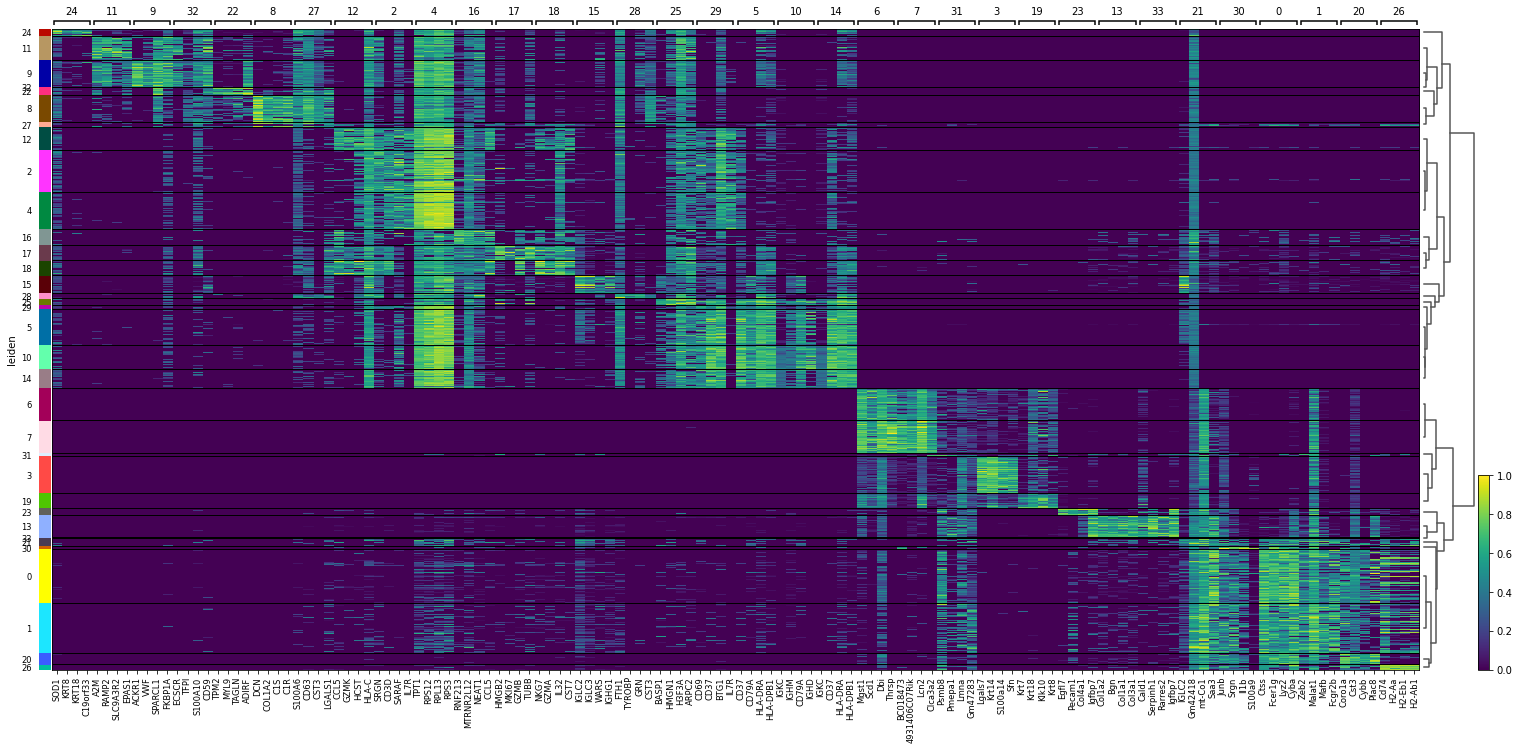

In [119]:

# preduce heatmap - similar to dot plot, but maybe not as useful

fig=sc.pl.rank_genes_groups_heatmap(merged_hy, figsize=(26, 12), n_genes=4, use_raw=False, show_gene_labels=True,standard_scale="var")


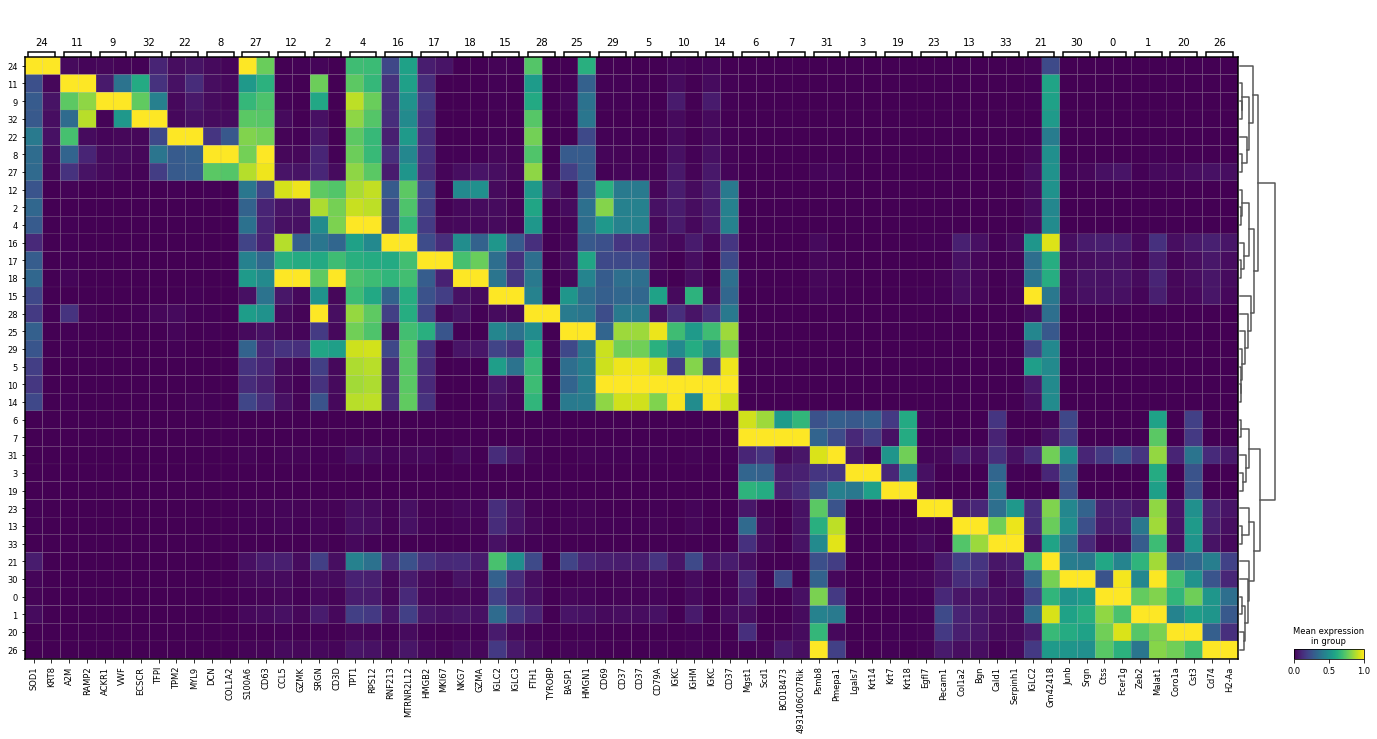

In [129]:

# matrix plot, n_genes=2

fig, ax = plt.subplots(1, 1, figsize=(24, 12))
sc.pl.rank_genes_groups_matrixplot(merged_hy, ax=ax, n_genes=2,use_raw=False,standard_scale="var")
fig.savefig("C:/Users/gperry/OneDrive - The Jackson Laboratory/Documents/GSBE Project - meeting recordings/figures/GlobalCluster/Global_Matrixplot_n2.png")


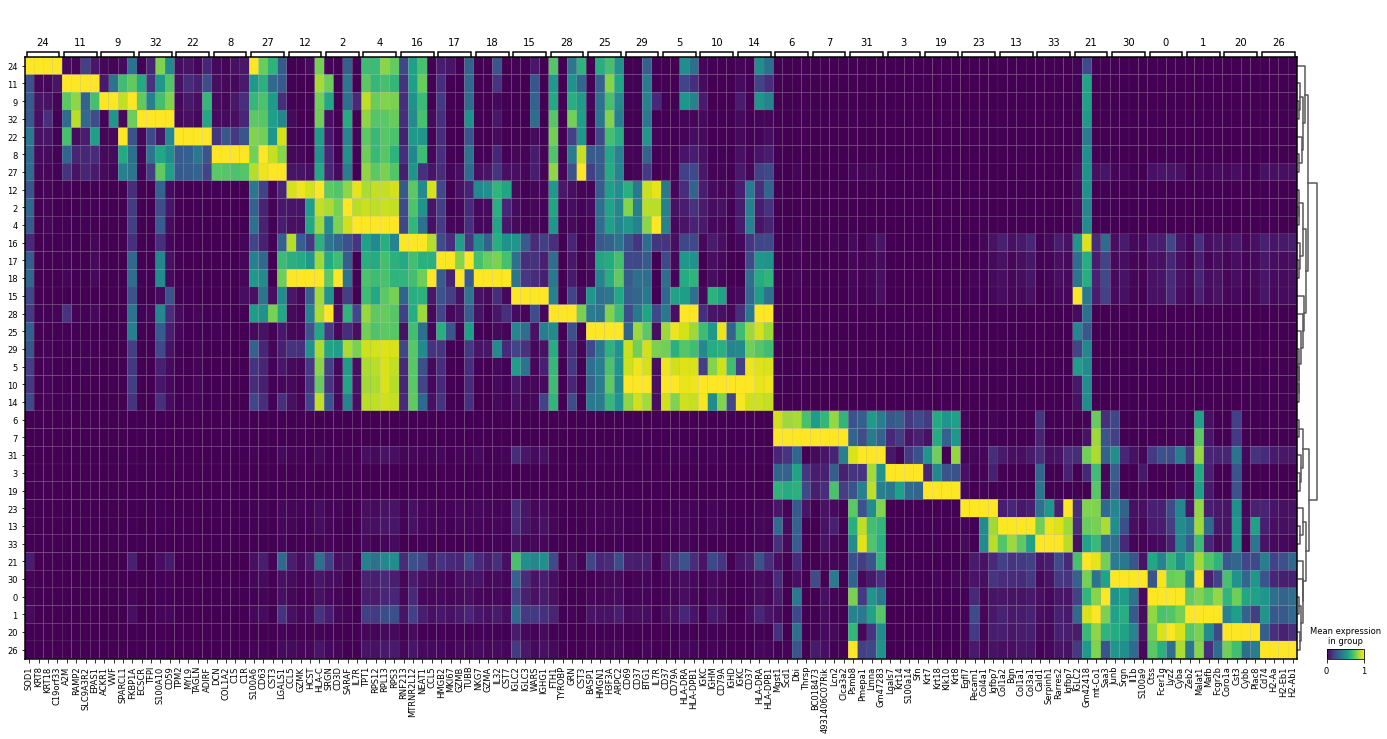

In [130]:

# matrix plot, n_genes=4

fig, ax = plt.subplots(1, 1, figsize=(24, 12))
sc.pl.rank_genes_groups_matrixplot(merged_hy, ax=ax, n_genes=4,use_raw=False,standard_scale="var")
fig.savefig("C:/Users/gperry/OneDrive - The Jackson Laboratory/Documents/GSBE Project - meeting recordings/figures/GlobalCluster/Global_Matrixplot_n4.png")


In [122]:


# check "B-Cell" clusters for common b-cell markers.

bcell_markers=["CD72","CD69","CD37","MS4A1","CD79A","CD79B","CD19"]

d=sc.get.obs_df(merged_hy, ["cell_type", "CD72","CD69","CD37","MS4A1","CD79A","CD79B","CD19"])
idx=d["CD72" and "CD69" and "CD37" and "MS4A1" and "CD79A"  and "CD79B" and "CD19"]>1
d[idx].head(10)
#idx.sum()


,cell_type,CD72,CD69,CD37,MS4A1,CD79A,CD79B,CD19
AAAGTCCAGAGAGTGA-1-primary_tumor_1,Hum_B-cells_1,0.000000,1.123018,2.598585,1.977180,2.431030,1.977180,1.123018
ACTATTCGTGACGTCC-1-primary_tumor_1,Hum_B-cells_1,0.000000,2.850164,2.641375,3.022799,2.017067,1.448828,2.641375
AGGCATTCATCACAGT-1-primary_tumor_1,Hum_B-cells_1,1.555825,1.054137,2.880629,3.230942,3.230942,2.137474,1.555825
AGGGCTCTCTACACTT-1-primary_tumor_1,Hum_B-cells_2,0.000000,3.031947,2.695728,2.695728,2.185492,2.185492,1.089826
AGTACCATCGAAGGAC-1-primary_tumor_1,Hum_B-cells_1,0.000000,2.889163,0.000000,3.424651,3.275913,1.657192,2.250146
ATTTCTGTCTGGGAGA-1-primary_tumor_1,Hum_B-cells_2,2.253836,2.455757,2.767410,2.455757,2.623676,2.623676,1.141369
CAACGGCCAGCTCTGG-1-primary_tumor_1,Hum_B-cells_1,1.742708,1.742708,2.344263,1.742708,2.861902,1.742708,1.210868
CGAAGGAAGGAACGCT-1-primary_tumor_1,Hum_B-cells_2,0.000000,3.554828,2.950925,2.950925,2.053657,2.308747,2.053657
CTAGGTATCGGAACTT-1-primary_tumor_1,Hum_B-cells_2,1.731755,2.975645,3.280087,3.580158,2.849375,2.076418,1.201554
CTGAGGCTCATGCGGC-1-primary_tumor_1,Hum_B-cells_1,2.504731,0.000000,1.557462,2.882586,3.073025,1.055488,1.890116


In [123]:

# better way to check "B-Cell" clusters for common b-cell markers.

markers = ["MS4A1", "CD72", "CD37", "CD79A", "CD79B","CD19"]
grouping_column = "leiden"
df = sc.get.obs_df(merged_hy, markers + [grouping_column])

mean_expression = df.loc[:, ~df.columns.isin([grouping_column])].mean(axis=0)
#mean_counts = df.loc[:, ~df.columns.isin(total_counts)].mean(axis=0) # this code still in progress- trying to add total mean counts to table

df, mean_expression = df.align(mean_expression, axis=1, copy=False)

g = (df).groupby(grouping_column)

frac = lambda z: sum(z) / z.shape[0]
frac.__name__ = "pos_frac"
g.aggregate([sum, frac])


CD19                   CD37                   CD72            \
                sum  pos_frac          sum  pos_frac          sum  pos_frac   
leiden                                                                        
0         26.792112  0.009739    72.173569  0.026235     1.998480  0.000726   
1         95.208984  0.037191   218.994965  0.085545    10.986734  0.004292   
2         26.140259  0.012261  2374.695312  1.113835    39.128860  0.018353   
3          0.000000  0.000000     1.746488  0.000909     0.000000  0.000000   
4         21.824020  0.011596  2133.768555  1.133777    31.412201  0.016691   
5       1094.070190  0.598507  4555.060547  2.491827  1206.687012  0.660113   
6          0.000000  0.000000     0.000000  0.000000     0.000000  0.000000   
7          0.000000  0.000000     0.232617  0.000139     0.000000  0.000000   
8         13.219084  0.009524    27.976118  0.020156     7.226208  0.005206   
9          0.295143  0.000214    15.432394  0.011199     7.779330  0.005645   
10       777.011353  0.626117  3169.418701  2.553923  1138.453857  0.917368   
11         1.164265  0.000956    16.019772  0.013153     2.167765  0.001780   
12        13.246931  0.011207  1238.064453  1.047432    50.968349  0.043120   
13         4.828988  0.004221    15.392288  0.013455     0.631556  0.000552   
14       517.678772  0.535345  2292.362793  2.370592   233.742294  0.241719   
15       358.967621  0.397528   760.857666  0.842589    64.064156  0.070946   
16         9.387111  0.011490   324.771118  0.397517    15.058463  0.018431   
17        17.203754  0.021478   453.025177  0.565574    30.237072  0.037749   
18         8.768688  0.011447   704.475098  0.919680    23.975117  0.031299   
19         0.000000  0.000000     0.000000  0.000000     0.000000  0.000000   
20         2.055458  0.003520     1.733965  0.002969     0.225212  0.000386   
21        39.559513  0.096960    78.722092  0.192946     6.291814  0.015421   
22         0.000000  0.000000     5.517795  0.014873     3.431304  0.009249   
23         1.660107  0.004676     0.270099  0.000761     0.000000  0.000000   
24         1.490632  0.004235     2.366389  0.006723     5.063177  0.014384   
25       231.280197  0.670377   751.331177  2.177771   253.273529  0.734126   
26         2.092681  0.007665     1.065660  0.003904     0.000000  0.000000   
27         0.715352  0.002620     8.240125  0.030184     0.000000  0.000000   
28         7.796016  0.028557   280.649506  1.028020    47.723789  0.174812   
29        66.497650  0.363375   366.236633  2.001293    65.031181  0.355362   
30         0.000000  0.000000     3.201431  0.020924     0.000000  0.000000   
31         0.722716  0.005736     1.933717  0.015347     0.000000  0.000000   
32         0.000000  0.000000     0.000000  0.000000     0.000000  0.000000   
33         0.000000  0.000000     0.000000  0.000000     0.000000  0.000000   

              CD79A                  CD79B                  MS4A1            
                sum  pos_frac          sum  pos_frac          sum  pos_frac  
leiden                                                                       
0         87.195587  0.031696    17.222481  0.006260   269.949371  0.098128  
1        283.878540  0.110890    58.170563  0.022723   771.886597  0.301518  
2        242.318909  0.113658   327.341522  0.153537   148.519974  0.069662  
3          0.000000  0.000000     0.000000  0.000000     0.000000  0.000000  
4        101.020294  0.053677   210.014343  0.111591   108.850380  0.057838  
5       4222.263672  2.309772  3082.035400  1.686015  3520.770264  1.926023  
6          0.000000  0.000000     0.000000  0.000000     0.000000  0.000000  
7          0.490555  0.000294     0.000000  0.000000     0.000000  0.000000  
8         21.676327  0.015617    24.766394  0.017843    20.011290  0.014417  
9          8.137897  0.005906   556.853333  0.404103     4.940702  0.003585  
10      3092.102539  2.491622  2276.823486  1.834668  2414.000244  1.945206  